# Exploration of 2023 Labels 

* Data annotated by Simon Geikie July/August 2023
* Data sourced for Ordnance Survey July/August 2023

| **Key**                     | **Meaning**                                                             |
|-----------------------------|-------------------------------------------------------------------------|
| A: Present                  | Present in OS data \| Present in the 2023 AP \| Present in 2014 AP      |
| B: Absent                   | Present in OS data \| Absent in the 2023 AP \| Absent in 2014 AP        |
| C: Absent (Present in 2014) | Absent in OS data \| Absent in the 2023 AP \| Present in 2014 AP        |
| E: Obscured (Vegetation)    | Obscured by trees, scrub or long grass.                                 |
| H: Urban                    | A mask created to simplify the detection of walls to only the open landscape |
| F: Present 1950             | Absent in OS data \| Present only on 1950's basemap                     |

In [21]:
# load libraries 
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from shapely.geometry import Polygon, LineString, MultiLineString, Point, GeometryCollection

In [27]:
# load data
walls = gpd.read_file("../content/labels/Walls.shp")
walls.crs

<Derived Projected CRS: EPSG:27700>
Name: OSGB36 / British National Grid
Axis Info [cartesian]:
- [east]: Easting (metre)
- [north]: Northing (metre)
Area of Use:
- undefined
Coordinate Operation:
- name: unnamed
- method: Transverse Mercator
Datum: Ordnance Survey of Great Britain 1936
- Ellipsoid: Airy 1830
- Prime Meridian: Greenwich

<AxesSubplot:>

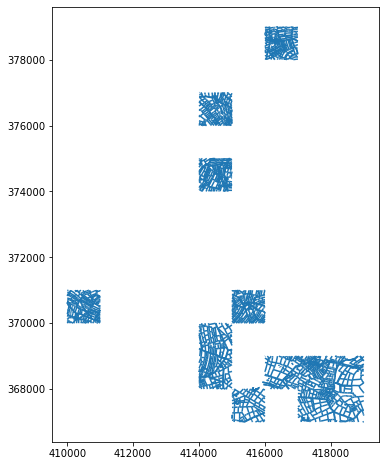

In [28]:
# take a look
walls.plot(figsize=(8,8))

In [29]:
walls.head(1)

,osid,toid,Label_2023,theme,istidal,changetype,ishistoric,isobscured,descriptio,versiondat,...,capturespe,geometry_e,descript_2,versionava,firstdigit,descript_3,versiona_1,FID_1,Shape_Leng,geometry
0,d4e434d7-ab01-49d6-af83-d747e155abae,osgb5000005154743092,H: Urban,Structures,0.0,New,0.0,0.0,Built Obstruction,2022-08-26,...,Rural,2014-07-24,2015-04-17,None,2015-04-17,2014-07-24,2022-08-27T00:00:00Z,0.0,0.666023,"LINESTRING (415354.513 367005.429, 415354.887 ..."


In [30]:
groups = walls['Label_2023'].unique()
groups

array(['H: Urban', 'Present (on MM and 2022 AP)',
       'Obscured (shadows and vegetation)',
       'Absent (present on MM but absent form 2022 AP)',
       'Absent (absent on MM present on 2014 AP)', 'Present (on 1955)'],
      dtype=object)

In [161]:
walls['length'] = walls.length

In [156]:
wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)
wall_t = wall_t.T.reset_index()
wall_t

C:\Users\alexad\AppData\Local\Temp\ipykernel_4172\3379901016.py:1: FutureWarning: The provided callable <function sum at 0x0000023AFE822C10> is currently using DataFrameGroupBy.sum. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "sum" instead.
  wall_t = pd.pivot_table(walls, columns='Label_2023', values='length', aggfunc=np.sum)


,Label_2023,length
0,Absent (absent on MM present on 2014 AP),1950.483098
1,Absent (present on MM but absent form 2022 AP),1775.155251
2,H: Urban,44043.508570
3,Obscured (shadows and vegetation),40182.210978
4,Present (on 1955),33302.576547
5,Present (on MM and 2022 AP),202160.536977


In [157]:
wall_t = wall_t.drop(index=(2))
wall_t.loc[(6)] = ['Total 1950', wall_t['length'].sum()]
wall_t

,Label_2023,length
0,Absent (absent on MM present on 2014 AP),1950.483098
1,Absent (present on MM but absent form 2022 AP),1775.155251
3,Obscured (shadows and vegetation),40182.210978
4,Present (on 1955),33302.576547
5,Present (on MM and 2022 AP),202160.536977
6,Total 1950,279370.962851


In [158]:
# just for the graph
wall_t = wall_t.drop(index=(4))

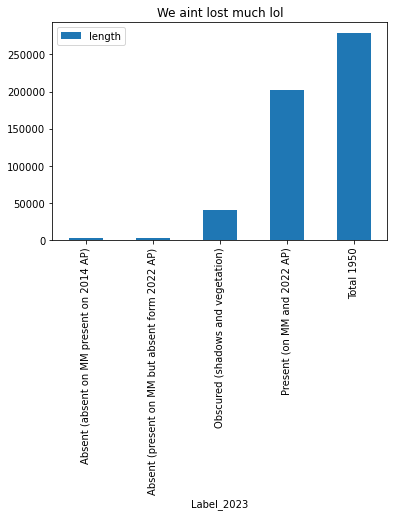

In [136]:
wall_t.plot(x='Label_2023', kind='bar', stacked=True,
        title='We aint lost much lol')
plt.show()

In [162]:
wall_t

,Label_2023,length
0,Absent (absent on MM present on 2014 AP),1950.483098
1,Absent (present on MM but absent form 2022 AP),1775.155251
3,Obscured (shadows and vegetation),40182.210978
5,Present (on MM and 2022 AP),202160.536977
6,Total 1950,279370.962851
